# Dog Cat Classfication with Tensorflow

---
format:
  html:
      code-tools: true
      toc: true
      toc-depth: 3
      toc-expand: 3
author: "Haoran Jia"
date: "2023-11-03"
---

**Can you distinguish between pictures of dogs and pictures of cats using machine learning algorithms?**

In this blog, we will be using Tensorflow to build several neural network models to classify dogs and cats. In this tutorial, you will be familiarized with image data augmentation, preprocessing, and the concept of transfer learning. It is strongly recommended to use colab or any other cloud services to access GPUs for faster training.  
![](https://www.boredpanda.com/blog/wp-content/uploads/2017/09/funny-cats-vs-dogs-comics-200-59c380533523b__700.jpg)

## Data Preparation

Let's start with the data import. We will be using a labeled dataset provided by Tensorflow, and we can retrive it from a url.

In [1]:
# package import
import os
from tensorflow.keras import utils
import tensorflow as tf

In [2]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets
train_dataset = utils.image_dataset_from_directory(train_dir,
                          shuffle=True,
                          batch_size=BATCH_SIZE,
                          image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                            shuffle=True,
                            batch_size=BATCH_SIZE,
                            image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


By running this code, we have created TensorFlow Datasets instances for training, validation, and testing. The data will be feeded to the machine learning in batches, and this avoids the need to load all the data into memory.

In our case, we used a special-purpose keras utility called `image_dataset_from_directory` to construct a Dataset. The first arguments specifies the directory of the dataset. The `shuffle` argument says that, when retrieving data from this directory, the order should be randomized. The `batch_size` determines how many data points are gathered from the directory at once. Here, for example, each time we request some data we will get 32 images from each of the data sets. Finally, the `image_size` specifies the size of the input images.

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

 This is technical code related to rapidly reading data. [Here for more](https://www.tensorflow.org/guide/data_performance)

We will be using `take` method to interact with the dataset. For example, `train_dataset.take(1)` will retrieve one batch (32 images with labels) from the training data. We can write a simple function to visualize some random pictures in the dataset.

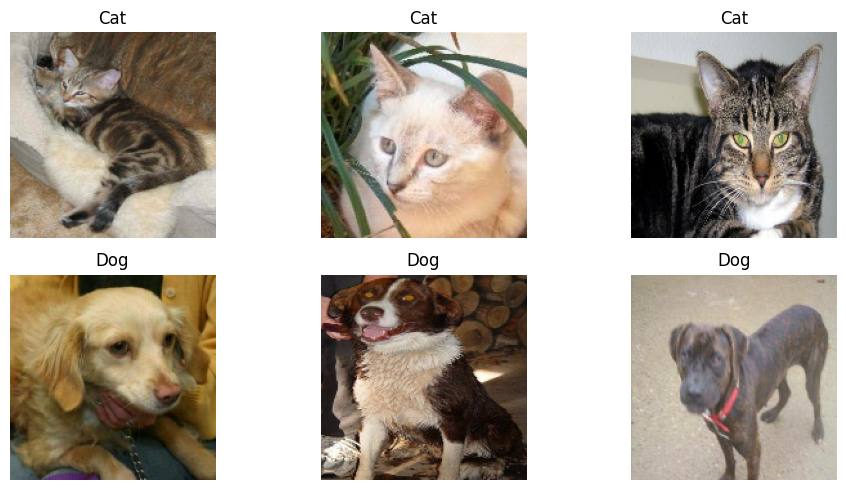

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_pictures(train_dataset, class_names):
    plt.figure(figsize=(10, 5))
    cat_images = []
    dog_images = []

    # Take 1 batches to ensure we get at least 3 of each class
    for images, labels in train_dataset.take(1):
        for i in range(len(labels)):
            # Class 0 for Cat, Class 1 for Dog
            if labels[i] == 0 and len(cat_images) < 3:
                cat_images.append(images[i].numpy().astype("uint8"))
            elif labels[i] == 1 and len(dog_images) < 3:
                dog_images.append(images[i].numpy().astype("uint8"))
            if len(cat_images) == 3 and len(dog_images) == 3:
                break
        if len(cat_images) == 3 and len(dog_images) == 3:
            break

    # Check if we found enough images
    if len(cat_images) < 3 or len(dog_images) < 3:
        raise ValueError("Not enough cat or dog images found in the batches taken.")

    # Plotting Cats
    for i in range(3):
        plt.subplot(2, 3, i+1)
        plt.imshow(cat_images[i])
        plt.title(class_names[0])
        plt.axis('off')

    # Plotting Dogs
    for i in range(3):
        plt.subplot(2, 3, i+4)
        plt.imshow(dog_images[i])
        plt.title(class_names[1])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

class_names = ['Cat', 'Dog'] # specify class names
show_random_pictures(train_dataset, class_names)


In [5]:
def counter(labels_iterator):
    # Initialize counters for both labels
    count_label_0 = 0  # for cat
    count_label_1 = 0  # for dog

    for label in labels_iterator:
        if label == 0:
            count_label_0 += 1
        elif label == 1:
            count_label_1 += 1

    # Print out the counts
    print(f'Number of cat images: {count_label_0}')
    print(f'Number of dog images: {count_label_1}')


In [6]:
# The following line of code will create an iterator to iterate through the dataset
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

counter(labels_iterator)

Number of cat images: 1000
Number of dog images: 1000


Since random guess will get 50% accuracy, we will treat this as the benchmark for improvement. Our models should do much better than a 50% baseline.

## Some Helper Functions

For convenience, we will create two helper functions to help us generalize the training of different models and the visualization of results. 

In [8]:
# Function to compile and train a model using training and validation datasets.
def compile_and_train(model, train_dataset, validation_dataset):
    # Compiling the model with 'adam' optimizer, loss function for multiclass classification, 
    # and setting 'accuracy' as the metric for evaluation.
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Training the model on the training dataset for 20 epochs
    # and validating it on validation dataset.
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=validation_dataset
    )

    # Returning the history object containing details of training and validation performance.
    return history

# Function to visualize the training and validation accuracy over epochs.
def plot_training_history(history):
    # Extracting accuracy metrics from the training history.
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Setting up the range of epochs for plotting.
    epochs_range = range(20)

    # Initializing a plot with a specific size.
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)

    # Plotting the training accuracy and validation accuracy over epochs.
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')

    # Adding legend to the plot in the lower right position.
    plt.legend(loc='lower right')

    # Adding a title to the plot.
    plt.title('Training and Validation Accuracy')

    # Displaying the plot.
    plt.show()


## Modeling

### 1. Simple CNN Model

We can start with a simple convolutional neural network model with three convolutional blocks and one classifier. The task is binary classification so we would define the last layer as `tf.keras.layers.Dense(2)` with two output neurons. `tf.keras.layers.BatchNormalization()` applies batch normalization to the inputs, which is a technique used to improve the performance and stability of the model.

In [9]:
# Define the model
model1 = tf.keras.Sequential([

    # First Convolutional Block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Third Convolutional Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])


In [10]:
history1 = compile_and_train(model1, train_dataset, validation_dataset)

Epoch 1/20
63/63 [==============================] - 32s 154ms/step - loss: 1.2226 - accuracy: 0.5705 - val_loss: 3.6936 - val_accuracy: 0.5087
Epoch 2/20
63/63 [==============================] - 8s 122ms/step - loss: 0.9374 - accuracy: 0.5825 - val_loss: 0.7353 - val_accuracy: 0.6027
Epoch 3/20
63/63 [==============================] - 8s 127ms/step - loss: 0.7614 - accuracy: 0.6440 - val_loss: 0.7294 - val_accuracy: 0.6015
Epoch 4/20
63/63 [==============================] - 8s 128ms/step - loss: 0.6735 - accuracy: 0.6870 - val_loss: 0.8700 - val_accuracy: 0.5804
Epoch 5/20
63/63 [==============================] - 8s 122ms/step - loss: 0.5658 - accuracy: 0.7295 - val_loss: 0.7950 - val_accuracy: 0.5792
Epoch 6/20
63/63 [==============================] - 9s 133ms/step - loss: 0.4795 - accuracy: 0.7855 - val_loss: 0.8196 - val_accuracy: 0.6423
Epoch 7/20
63/63 [==============================] - 9s 136ms/step - loss: 0.4845 - accuracy: 0.7840 - val_loss: 0.7983 - val_accuracy: 0.6163
Epoch

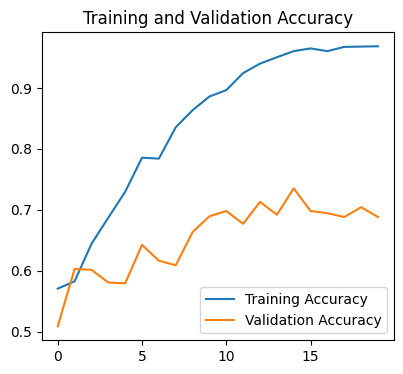

In [12]:
plot_training_history(history1)

**As we can observe, the training accuracy goes all the way up to 0.97, while the validation accuracy fluctuates around 0.68.** This is a clear signal of overfitting. But there is at least a 0.18 improvement over the baseline.

### 2. Model with Data Augmentation

Now we are going to add some data augmentation layers to the model. Data augmentation refers to the practice of including modified copies of the same image in the training set. For example, a picture of a cat is still a picture of a cat even if we flip it upside down or rotate it 90 degrees. We can include such transformed versions of the image in our training process in order to help our model learn so-called invariant features of our input images. We will start by looking at the actual examples of flipping and rotation. 

####  RandomFlip Augmentation

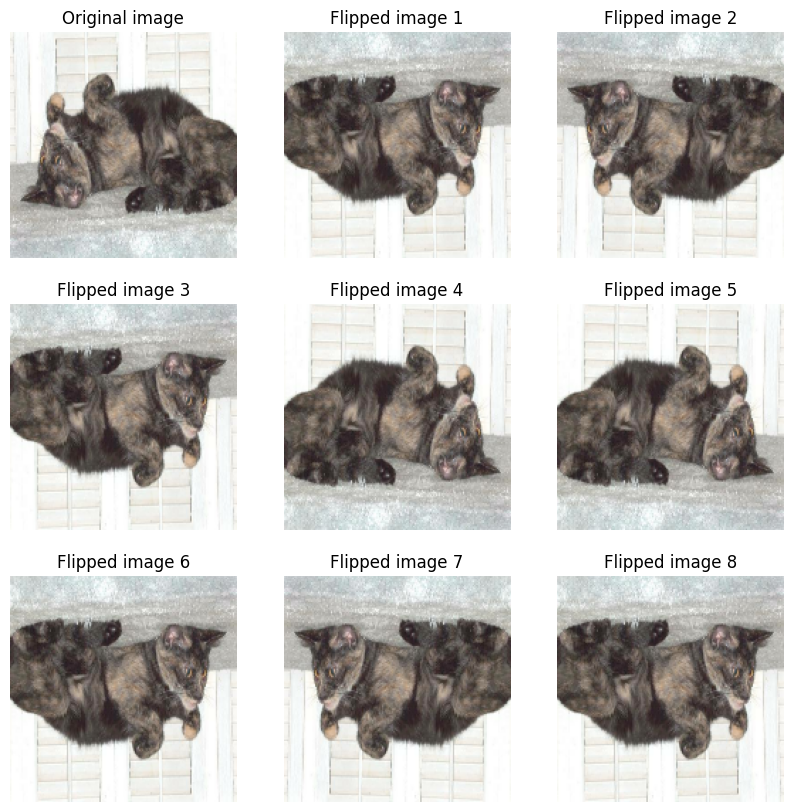

In [14]:
def visualize_random_flip(image):
    random_flip_layer = tf.keras.layers.RandomFlip("horizontal_and_vertical")

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title('Original image')
    plt.axis('off')
    # Apply the RandomFlip layer to the same image several times
    for i in range(8):
        plt.subplot(3, 3, i+2)
        flipped_image = random_flip_layer(image, training=True)
        plt.imshow(flipped_image.numpy().astype("uint8"))
        plt.title(f'Flipped image {i+1}')
        plt.axis('off')
    plt.show()

# Retrieve a batch of images from the training dataset and visualize the first one
for images, _ in train_dataset.take(1):
    visualize_random_flip(images[0])


#### RandomRotation Augmentation

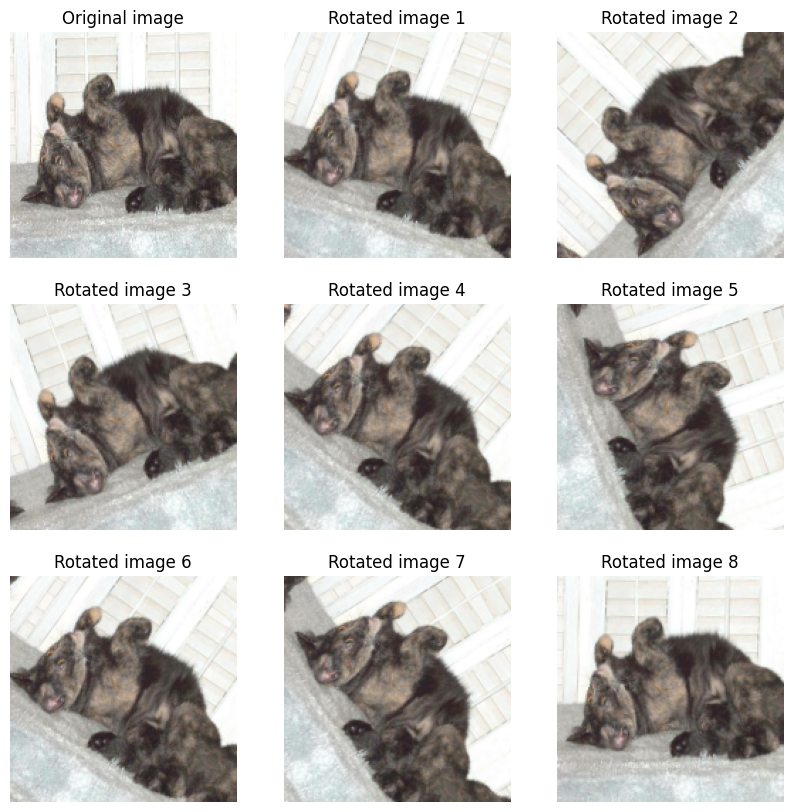

In [15]:
def visualize_random_rotation(image):
    random_rotation_layer = tf.keras.layers.RandomRotation(0.2)  # 20% of 360 degrees

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title('Original image')
    plt.axis('off')
    # Apply the RandomRotation layer to the same image several times
    for i in range(8):
        plt.subplot(3, 3, i+2)
        rotated_image = random_rotation_layer(image, training=True)
        plt.imshow(rotated_image.numpy().astype("uint8"))
        plt.title(f'Rotated image {i+1}')
        plt.axis('off')
    plt.show()

# visualize the first one
visualize_random_rotation(images[0])

#### Build a Model with Data Augmentation

Now we are creating a new model called `model2` in which the first two layers are augmentation layers, while other layers remain similar to model1.

In [16]:
# Create the Sequential model
model2 = tf.keras.Sequential([
    # Data Augmentation Block
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),

    # First Convolutional Block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Third Convolutional Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])

#### Train and Visualize the Result

In [17]:
history2 = compile_and_train(model2, train_dataset, validation_dataset)

Epoch 1/20
63/63 [==============================] - 13s 127ms/step - loss: 1.2798 - accuracy: 0.5445 - val_loss: 3.9599 - val_accuracy: 0.4802
Epoch 2/20
63/63 [==============================] - 8s 130ms/step - loss: 0.9775 - accuracy: 0.5725 - val_loss: 0.8683 - val_accuracy: 0.5656
Epoch 3/20
63/63 [==============================] - 9s 139ms/step - loss: 0.8225 - accuracy: 0.6055 - val_loss: 0.6811 - val_accuracy: 0.6188
Epoch 4/20
63/63 [==============================] - 9s 129ms/step - loss: 0.7024 - accuracy: 0.6385 - val_loss: 0.6933 - val_accuracy: 0.6312
Epoch 5/20
63/63 [==============================] - 9s 139ms/step - loss: 0.6925 - accuracy: 0.6445 - val_loss: 0.6573 - val_accuracy: 0.6151
Epoch 6/20
63/63 [==============================] - 8s 126ms/step - loss: 0.6302 - accuracy: 0.6770 - val_loss: 0.6138 - val_accuracy: 0.6770
Epoch 7/20
63/63 [==============================] - 9s 133ms/step - loss: 0.6284 - accuracy: 0.6745 - val_loss: 0.6516 - val_accuracy: 0.6658
Epoch

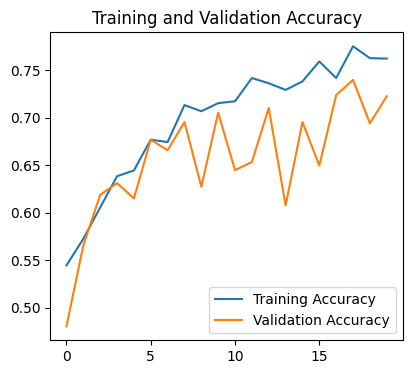

In [18]:
plot_training_history(history2)

**As we can observe, the training accuracy goes to 0.77, about 0.2 lower than model1, but the validation accuracy becomes higher than before, reaching a maximum of 0.74.** This shows that data augmentation has helped us balance the bias of the model, but the model is still not sufficient to make accuracy predictions, though it is 24% higher in accuracy than random guess.

### 3. Model with Data Preprocessing

Sometimes, it can be helpful to make simple transformations to the input data. For example, in this case, the original data has pixels with RGB values between 0 and 255, but many models will train faster with RGB values normalized between 0 and 1, or possibly between -1 and 1. These are mathematically identical situations, since we can always just scale the weights. But if we handle the scaling prior to the training process, we can spend more of our training energy handling actual signal in the data and less energy having the weights adjust to the data scale. 

In the following section, we will define a function to create a preprocessor for the input, and incoporate this into our model.  

In [41]:
# Define the preprocessor as the first layer of the model
def create_preprocessor():
    i = tf.keras.Input(shape=(160, 160, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
    preprocessor = tf.keras.Model(inputs=[i], outputs=[x])
    return preprocessor

# Create the model with the preprocessor layer, data augmentation, and the rest of the architecture
def create_model3():
    preprocessor = create_preprocessor()
    model = tf.keras.Sequential([
        preprocessor,
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),

        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Classifier
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2)
    ])
    return model

Epoch 1/20
63/63 [==============================] - 13s 154ms/step - loss: 1.2568 - accuracy: 0.5475 - val_loss: 2.8958 - val_accuracy: 0.4950
Epoch 2/20
63/63 [==============================] - 8s 122ms/step - loss: 0.8847 - accuracy: 0.6115 - val_loss: 0.8993 - val_accuracy: 0.5087
Epoch 3/20
63/63 [==============================] - 9s 133ms/step - loss: 0.7476 - accuracy: 0.6495 - val_loss: 2.0710 - val_accuracy: 0.4839
Epoch 4/20
63/63 [==============================] - 10s 150ms/step - loss: 0.6810 - accuracy: 0.6555 - val_loss: 2.4050 - val_accuracy: 0.4950
Epoch 5/20
63/63 [==============================] - 8s 124ms/step - loss: 0.6590 - accuracy: 0.6835 - val_loss: 1.4140 - val_accuracy: 0.5025
Epoch 6/20
63/63 [==============================] - 10s 150ms/step - loss: 0.6129 - accuracy: 0.6980 - val_loss: 1.4951 - val_accuracy: 0.5483
Epoch 7/20
63/63 [==============================] - 10s 148ms/step - loss: 0.5817 - accuracy: 0.7125 - val_loss: 1.1408 - val_accuracy: 0.5582
Ep

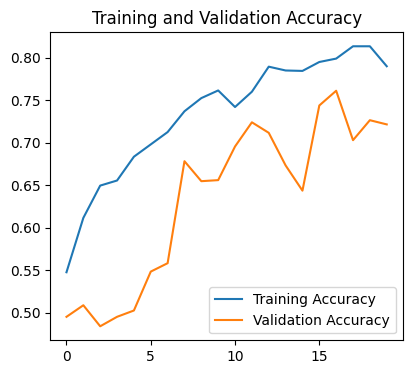

In [42]:
# Build model, train, and visualize the result
model3 = create_model3()
history3 = compile_and_train(model3, train_dataset, validation_dataset)
plot_training_history(history3)

**There is a constant increase in training and validation accuracy, where the training accuracy increases less sharply after reaching 0.78, and validation accuracy fluctuates around 0.7.** Though the training accuracy is still higher than the validation accuracy, the overfitting problem is less severe than the previous two models. As the training going on, the training and validation accuracy increase at the same time. 

### 4. Model with Tansfer Learning

So far we are building everything and train randomized weights from scratch. But the idea of transfer learning allows us to make use of some pretrained models that does a related task. For example, a model that is trained on `imagenet` could help us locate features in a picture so that we only need to add a classifier and fine-tune the whole model to get the results.

In [24]:
def create_model4():
    # Download and configure the MobileNetV2 base model
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                  include_top=False,
                                                  weights='imagenet')
    base_model.trainable = False

    # Define the base_model_layer using the base model
    i = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(i, training=False)
    base_model_layer = tf.keras.Model(inputs=[i], outputs=[x])

    # Create the preprocessor layer
    preprocessor = create_preprocessor()  # Assuming this function was defined as before

    # Define the new model using the layers described
    model4 = tf.keras.Sequential([
        preprocessor,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        base_model_layer,
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dropout(0.2),  # Optional, adjust the rate as needed
        tf.keras.layers.Dense(2)  # Output layer with 2 neurons for binary classification
    ])
    return model4


Epoch 1/20
63/63 [==============================] - 13s 155ms/step - loss: 1.2855 - accuracy: 0.7155 - val_loss: 0.1718 - val_accuracy: 0.9455
Epoch 2/20
63/63 [==============================] - 4s 56ms/step - loss: 0.5989 - accuracy: 0.8450 - val_loss: 0.1537 - val_accuracy: 0.9480
Epoch 3/20
63/63 [==============================] - 4s 56ms/step - loss: 0.5038 - accuracy: 0.8670 - val_loss: 0.1679 - val_accuracy: 0.9480
Epoch 4/20
63/63 [==============================] - 5s 84ms/step - loss: 0.4607 - accuracy: 0.8830 - val_loss: 0.1174 - val_accuracy: 0.9629
Epoch 5/20
63/63 [==============================] - 5s 74ms/step - loss: 0.4095 - accuracy: 0.8925 - val_loss: 0.0826 - val_accuracy: 0.9715
Epoch 6/20
63/63 [==============================] - 5s 81ms/step - loss: 0.3745 - accuracy: 0.8950 - val_loss: 0.1055 - val_accuracy: 0.9567
Epoch 7/20
63/63 [==============================] - 4s 57ms/step - loss: 0.3485 - accuracy: 0.9015 - val_loss: 0.1217 - val_accuracy: 0.9530
Epoch 8/20


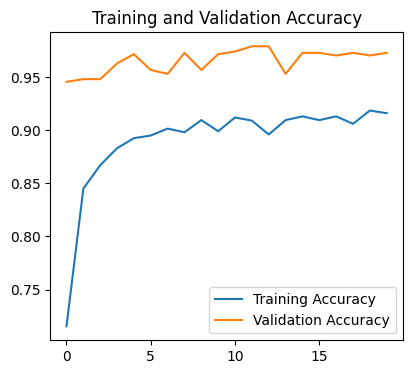

In [25]:
model4 = create_model4()
history4 = compile_and_train(model4, train_dataset, validation_dataset)
# Visualize the training history
plot_training_history(history4)

**The validation accuracy is consistantly above 0.97, and the training accuracy is around 0.9.** The accuracy is significantly higher than the previous three models, and overfitting is not observed. 

In [26]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 160, 160, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 model_1 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 1280)             

From the model summary, we can see that most of the parameters are from the pretrined model within the `base_model_layer`. 

## Evaluate Best Model on Testset

In [28]:
# Evaluate on test set
test_loss, test_accuracy = model4.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

6/6 [==============================] - 1s 88ms/step - loss: 0.0464 - accuracy: 0.9740
Test Accuracy: 97.40%


As a result, the model gets 97.40% accuracy on the unseen testset.